In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_openml

import sys, sklearn
np.random.seed(42)

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.12.4
NumPy: 1.26.4
Pandas: 2.2.2
scikit-learn: 1.4.2


1.1 Fundamentos de la técnica
El Perceptrón es un clasificador lineal que busca un hiperplano que separe dos clases.
Ajusta sus pesos cada vez que se equivoca. Es rápido, simple e interpretable.
Es la base de redes neuronales más complejas.

1.2 Modelo Matemático del Perceptrón
𝑦^=sign(𝑤⊤𝑥+𝑏)
Cuando el modelo se equivoca:
𝑤←𝑤+𝜂 𝑦(𝑖)𝑥(𝑖),
𝑏←𝑏+𝜂 𝑦(𝑖)
Donde (η) es la tasa de aprendizaje.

1.3 Descripción de la librería y funciones
sklearn.linear_model.Perceptron: implementación optimizada.
Pipeline: agrupa estandarización + modelo.
StandardScaler: normaliza los datos.
train_test_split: separa datos en entrenamiento y prueba.
accuracy_score, confusion_matrix, classification_report: métricas de rendimiento.

1.4 Pipeline — paso a paso
1.4.1 Feature Engineering
Usaremos el dataset Banknote Authentication del repositorio UCI (vía OpenML).
Cada registro representa estadísticas de una imagen de billete: varianza, asimetría, curtosis y entropía.
El objetivo (class) indica si el billete es auténtico (1) o falso (0).

In [3]:
# Cargar dataset Banknote Authentication desde OpenML
from sklearn.datasets import fetch_openml

bank = fetch_openml(data_id=1462, as_frame=True)  # UCI Banknote Authentication
df = bank.frame.copy()

# Mostrar nombres de columnas disponibles
print("Columnas disponibles:", df.columns.tolist())

# Detectar automáticamente la columna objetivo
target_col = bank.target_names[0] if hasattr(bank, "target_names") else "class"
print("Columna objetivo detectada:", target_col)

# Limpiar y preparar
df[target_col] = df[target_col].astype(int)  # asegurar que sea numérica
X = df.drop(columns=[target_col]).values
y = df[target_col].values

print("Shape del dataset:", X.shape)
df.head()


Columnas disponibles: ['V1', 'V2', 'V3', 'V4', 'Class']
Columna objetivo detectada: Class
Shape del dataset: (1372, 4)


,V1,V2,V3,V4,Class
0,3.62160,8.6661,-2.8073,-0.44699,1
1,4.54590,8.1674,-2.4586,-1.46210,1
2,3.86600,-2.6383,1.9242,0.10645,1
3,3.45660,9.5228,-4.0112,-3.59440,1
4,0.32924,-4.4552,4.5718,-0.98880,1


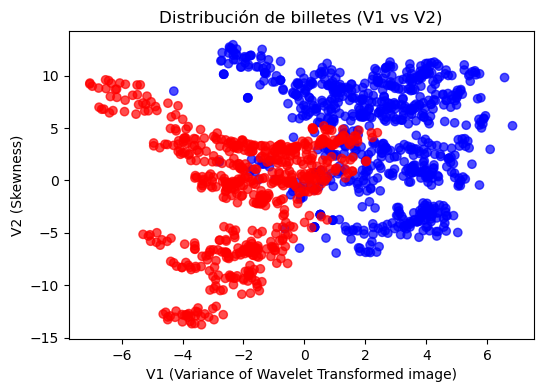

In [6]:
plt.figure(figsize=(6, 4))
plt.scatter(df["v1"], df["v2"], c=y, alpha=0.7, cmap="bwr")
plt.title("Distribución de billetes (V1 vs V2)")
plt.xlabel("V1 (Variance of Wavelet Transformed image)")
plt.ylabel("V2 (Skewness)")
plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

perceptron_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", Perceptron(max_iter=1000, tol=1e-3, eta0=1.0, random_state=42))
])

perceptron_clf.fit(X_train, y_train)
print("Modelo entrenado ✅")


Modelo entrenado ✅


1.4.2 Model Selection
El Perceptrón es ideal aquí porque los datos son casi linealmente separables.
Si tuvieras fronteras no lineales, podrías usar un modelo con kernel (SVM) o redes neuronales.

1.4.3 Model Training
Dividimos los datos en entrenamiento (75%) y prueba (25%).
Creamos un Pipeline que incluye la estandarización y el modelo.

1.4.4 Prediction
Probamos el modelo con ejemplos aleatorios para verificar cómo clasifica billetes auténticos y falsos.

In [8]:
def predict_and_check(model, X_, y_, n=8):
    idx = np.random.choice(len(X_), size=n, replace=False)
    X_sub, y_sub = X_[idx], y_[idx]
    y_hat = model.predict(X_sub)
    for i, (x_row, yt, yp) in enumerate(zip(X_sub, y_sub, y_hat), start=1):
        correcto = "✔" if yt == yp else "✖"
        print(f"{i:02d}) y_true={yt}, y_pred={yp} -> {correcto}, features={np.round(x_row, 3)}")

predict_and_check(perceptron_clf, X_test, y_test, n=8)


01) y_true=1, y_pred=1 -> ✔, features=[ 3.138 -4.11   4.57   0.99 ]
02) y_true=2, y_pred=2 -> ✔, features=[ 0.406  1.349 -1.45  -0.559]
03) y_true=1, y_pred=1 -> ✔, features=[2.467 1.393 1.712 0.414]
04) y_true=1, y_pred=1 -> ✔, features=[-1.858  7.886 -1.664 -1.838]
05) y_true=1, y_pred=1 -> ✔, features=[ 1.91   8.871 -2.339 -0.756]
06) y_true=1, y_pred=1 -> ✔, features=[-0.295  9.049 -0.527 -2.079]
07) y_true=2, y_pred=2 -> ✔, features=[-2.124 -6.897  5.599 -0.472]
08) y_true=1, y_pred=1 -> ✔, features=[-2.495 11.147  1.935 -3.464]


1.4.5 Model Evaluation
Calculamos métricas para evaluar el desempeño del Perceptrón.
Usamos accuracy, matriz de confusión y reporte por clase.

In [9]:
y_pred = perceptron_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy en test: {acc:.4f}\n")
print("Matriz de confusión:\n", cm, "\n")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))


Accuracy en test: 0.9825

Matriz de confusión:
 [[186   5]
 [  1 151]] 

Reporte de clasificación:
               precision    recall  f1-score   support

           1     0.9947    0.9738    0.9841       191
           2     0.9679    0.9934    0.9805       152

    accuracy                         0.9825       343
   macro avg     0.9813    0.9836    0.9823       343
weighted avg     0.9828    0.9825    0.9825       343



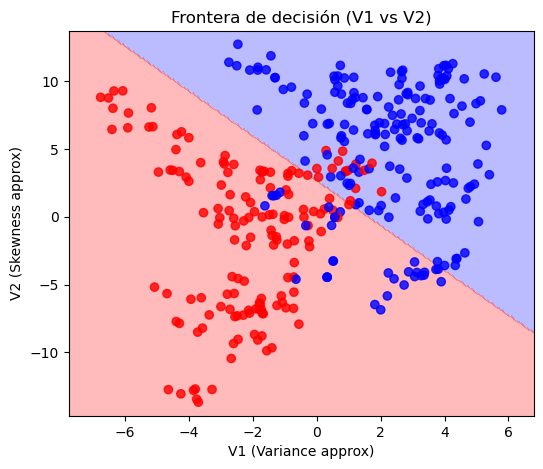

In [11]:
# Visualización (solo para 2 features, usando v1 y v2)
def plot_decision_boundary(model, X_, y_, title="Frontera de decisión (2D)"):
    x_min, x_max = X_[:,0].min() - 1.0, X_[:,0].max() + 1.0
    y_min, y_max = X_[:,1].min() - 1.0, X_[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
    plt.scatter(X_[:,0], X_[:,1], c=y_, cmap="bwr", alpha=0.8)
    plt.title(title)
    plt.xlabel("V1 (Variance approx)")
    plt.ylabel("V2 (Skewness approx)")
    plt.show()

# Entrenamiento visual con las dos primeras features (v1, v2)
X2 = df[["v1", "v2"]].values
Xtr2, Xte2, ytr2, yte2 = train_test_split(X2, y, test_size=0.25, random_state=42, stratify=y)

perceptron_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", Perceptron(max_iter=1000, tol=1e-3, random_state=42))
]).fit(Xtr2, ytr2)

plot_decision_boundary(perceptron_2d, Xte2, yte2, title="Frontera de decisión (V1 vs V2)")
